In [1]:
using PyPlot
using Random
using Distributions

In [2]:
include("../src/model.jl");
include("../src/ensemble.jl");
include("../src/diagnostics.jl");
include("../src/optimize.jl");
include("../src/plotting.jl");

In [10]:
t = Array(2020:1.:2100);
β = 1.5 # damages (trillion $ / celsius^2)
utility_discount_rate = 0.014 # low value (stern review)
GWP = 100. # global world product (trillion $)
reduce_cost = 0.10*GWP
remove_cost = 0.20*GWP
geoeng_cost = 0.30*GWP
adapt_cost = 0.25*GWP
economics = Economics(
    β, utility_discount_rate,
    reduce_cost, remove_cost, geoeng_cost, adapt_cost,
    0., 0., 0., 0.,
    baseline_emissions(t)
)

Economics(1.5, 0.014, 10.0, 20.0, 30.0, 25.0, 0.0, 0.0, 0.0, 0.0, [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0  …  1.125, 1.0, 0.875, 0.75, 0.625, 0.5, 0.375, 0.25, 0.125, 0.0])

In [11]:
Random.seed!(1)
d = Normal(0.65, 0.13)
feedback_samples = rand(d, 20)
feedback_samples[feedback_samples .>= 0.999] .= NaN
feedback_samples[feedback_samples .<= 0.] .= NaN

ECS₀ = 1.2
ECS_samples = ECS₀ ./ (1. .-feedback_samples);

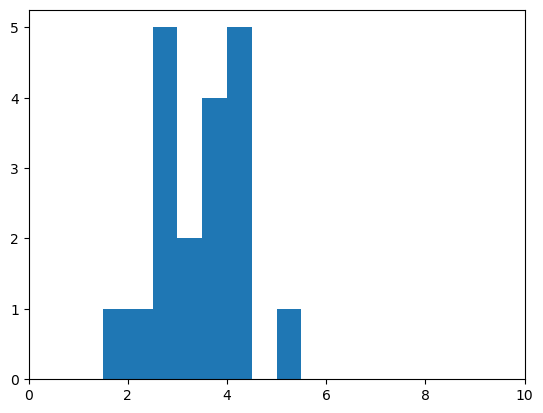

(0, 10)

In [12]:
hist(ECS_samples, bins=0.:0.5:20.)
xlim([0,10])

Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converged after 501 iterations. Converge

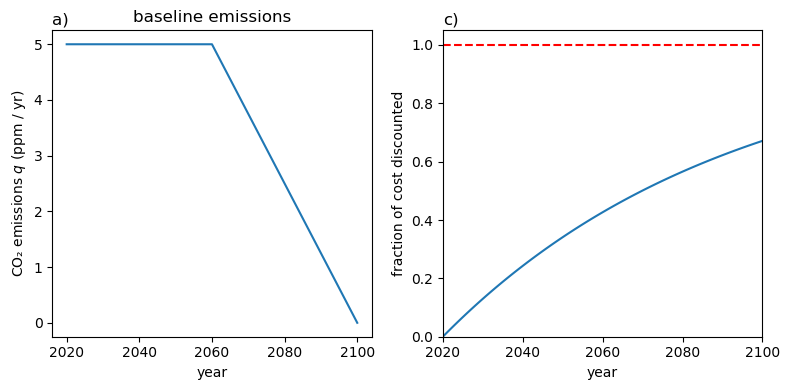

Converged after 501 iterations. Converged after 501 iterations. 

In [13]:
ensemble = Dict{String, ClimateModel}();
first = true
for member_id in 1:length(ECS_samples)
    present_year = 2020.
    ECS = ECS_samples[member_id]
    name = "member $member_id";
    controls = init_linear_controls(t);
    model = ClimateModel(name, ECS, t, controls, economics, present_year);
    optimize!(model)
    
    if CO₂(model)[end-1] < 1.e5
        ensemble[name] = model
    end
        
    if first; plot_setup(model); first=false; end
end

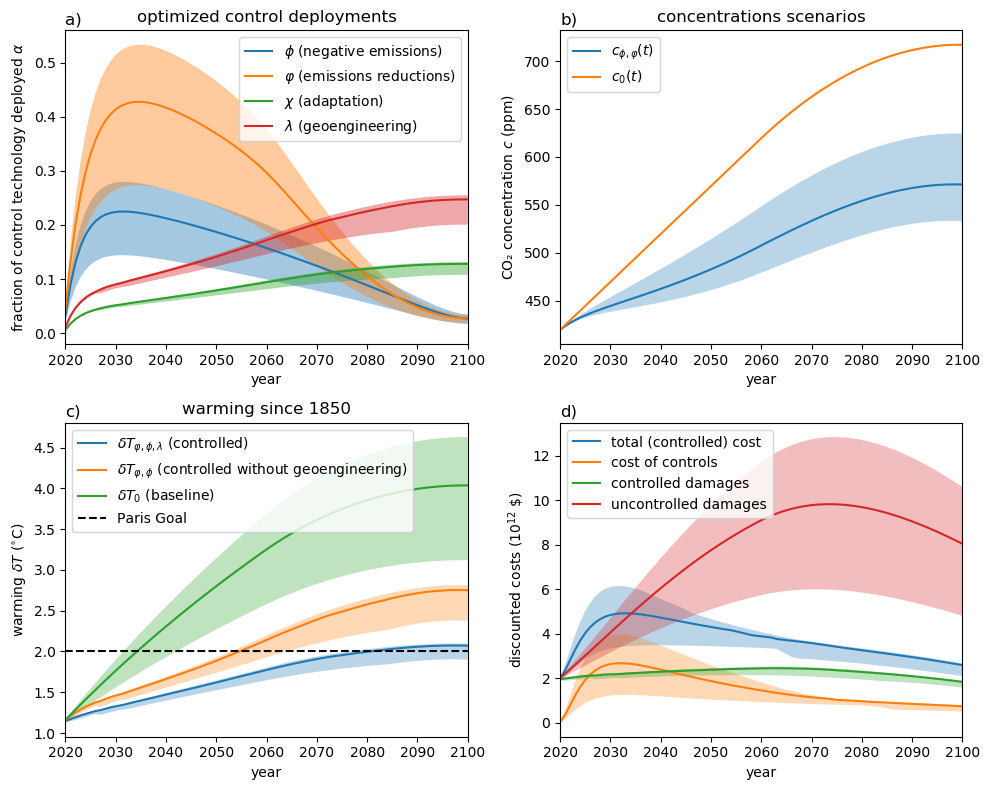

In [14]:
plot_ensemble_stats(ensemble, t)